# Signature verification : DTW Computation and Evaluation

## Import Libraries

In [1]:
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
from tslearn.metrics import dtw
from itertools import combinations
import operator
from sklearn.metrics import auc

## Import Normalized Signatures

In [2]:
normDataIsAvailable = None
if os.path.isdir('../dataset'):
    dataset_fold = os.path.join('..', 'dataset')
    norm_enrollment_file = os.path.join(dataset_fold, 'norm_enrollment.pkl')
    norm_verification_file = os.path.join(dataset_fold, 'norm_verification.pkl')
    if (not os.path.isfile(norm_enrollment_file) or not os.path.isfile(norm_verification_file)):
        print('Error : normalised data is not available')
    else:
        normDataIsAvailable = True
else:
    print('Error : dataset folder does not exist.')

if normDataIsAvailable:
    with open(norm_verification_file, 'rb') as f:
        verification_dict = pickle.load(f)
    print('Dict of verification data loaded.')
    with open(norm_enrollment_file, 'rb') as f:
        enrollment_dict = pickle.load(f)
    print('Dict of enrollment data loaded.')

Dict of verification data loaded.
Dict of enrollment data loaded.


## Import ground-truth

In [3]:
groundTruth = {}
if not os.path.isfile('./../groundtruth/gt.txt'):
    print("Error : gt.txt file not found in folder groundtruth.")
else:
    with open("./../groundtruth/gt.txt", "r") as f:
        lines = f.readlines()
        for l in lines:
            token = l.replace("\n", "").split(" ")
            groundTruth[token[0]] = token[1]
    print("Ground-truth imported.")

Ground-truth imported.


## Compute mean distance over genuine signatures for each user

In [4]:
def compute_dtw(signature_a, signature_b):
    dist = dtw(signature_a, signature_b, global_constraint="sakoe_chiba", sakoe_chiba_radius=3)
    return dist

def genuineDist(g_signatures):
    users_genuine_dist = {}
    for user in g_signatures.keys():
        print(f">Mean distance computation for user {user} in progress")
        all_distances = [compute_dtw(signature_a, signature_b) 
                         for signature_a, signature_b in combinations(g_signatures[user], 2)]
        users_genuine_dist[user] = np.mean(all_distances)
    return users_genuine_dist

In [5]:
users_genuine_dist = genuineDist(enrollment_dict)
print("Mean distance computation of genuine signatures for each user done.")

>Mean distance computation for user 001 in progress
>Mean distance computation for user 002 in progress
>Mean distance computation for user 003 in progress
>Mean distance computation for user 004 in progress
>Mean distance computation for user 005 in progress
>Mean distance computation for user 006 in progress
>Mean distance computation for user 007 in progress
>Mean distance computation for user 008 in progress
>Mean distance computation for user 009 in progress
>Mean distance computation for user 010 in progress
>Mean distance computation for user 011 in progress
>Mean distance computation for user 012 in progress
>Mean distance computation for user 013 in progress
>Mean distance computation for user 014 in progress
>Mean distance computation for user 015 in progress
>Mean distance computation for user 016 in progress
>Mean distance computation for user 017 in progress
>Mean distance computation for user 018 in progress
>Mean distance computation for user 019 in progress
>Mean distan

## Compute dissimilarity for each verification signature with the 5 genuine ones

In [6]:
def verifDist(genuine_signatures, verification_signatures):
    users_verif_dist = {}
    for user in verification_signatures.keys():
        dict_signature_dist = {}
        print(f">Distance computation for user {user} in progress")
        for v_signature in verification_signatures[user]:
            print(f">Compare signature {v_signature[0]} with the 5 genuine signatures")
            computed_dists = []
            for g_signature in genuine_signatures[user]:
                computed_dists.append(compute_dtw(g_signature, v_signature[1]))
            dict_signature_dist[v_signature[0]] = np.mean(computed_dists)
        users_verif_dist[user] = dict_signature_dist
    print("All distances computed.")
    return users_verif_dist

In [7]:
if not os.path.isdir('../results'):
    os.mkdir('../results')
results_fold = os.path.join('..', 'results')
dist_file = os.path.join(results_fold, 'dist_results.pkl')
if os.path.isfile(dist_file):
    print("Dissimilarity for each verification signature already computed.")
    with open(dist_file, 'rb') as f:
        users_verif_dist = pickle.load(f)  
else:
    users_verif_dist = verifDist(enrollment_dict, verification_dict)
    with open('./../results/dist_results.pkl', 'wb') as f:
        pickle.dump(users_verif_dist, f, pickle.HIGHEST_PROTOCOL)

Dissimilarity for each verification signature already computed.


## Find the optimal threshold to choose if a signature is genuine or fake

In [8]:
def predict_for_threshold(users_genuine_dist, users_verif_dist):
    thresholds = np.arange(0, 25, 0.1)
    predictions = {}
    for threshold in thresholds:
        predictions[threshold]={}
        for user in users_verif_dist.keys():
            for signature in users_verif_dist[user]:
                dist = users_verif_dist[user][signature]
                genuine_dist = users_genuine_dist[user]
                if abs(dist-genuine_dist)<=threshold:
                    predictions[threshold][user+"-"+signature]='g'
                else:
                    predictions[threshold][user+"-"+signature]='f'
    return predictions

In [9]:
def evaluate_accuracy_threshold(predictions):
    accuracy = {}
    for threshold in predictions.keys():
        correct = 0
        wrong = 0
        for signature in predictions[threshold].keys():
            if groundTruth[signature]==predictions[threshold][signature]:
                correct+=1
            else:
                wrong+=1
        accuracy[threshold]= correct/(correct+wrong)
    return accuracy

In [10]:
def plot_acc(accuracy):
    lists = sorted(accuracy.items()) 
    x, y = zip(*lists)
    plt.plot(x, y)
    plt.title("Accuracy of the signature verification ")
    plt.xlabel("Threshold")
    plt.yscale('linear')
    plt.ylabel("Accuracy")
    plt.show()

In [11]:
# find the key of the max value in a dictionary
def keywithmaxval(d): 
     v=list(d.values())
     k=list(d.keys())
     return k[v.index(max(v))]

In [12]:
predictions = predict_for_threshold(users_genuine_dist, users_verif_dist)
print("Predictions created.")

Predictions created.


In [13]:
dict_accuracy = evaluate_accuracy_threshold(predictions)
print("Dictionary of accuracy for each threshold created.")

Dictionary of accuracy for each threshold created.


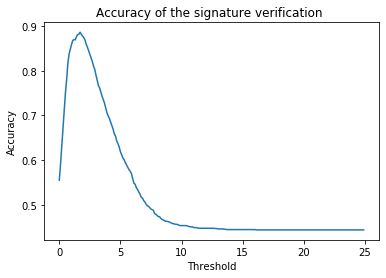

In [14]:
plot_acc(dict_accuracy)

In [15]:
keywithmaxval(dict_accuracy)

1.7000000000000002

The optimal theshold is 1.7

## Compute the predictions with optimal threshold

In [16]:
def predict(users_genuine_dist, users_verif_dist):
    threshold = 1.7
    predictions = {}
    for user in users_verif_dist.keys():
        for signature in users_verif_dist[user]:
            dist = users_verif_dist[user][signature]
            genuine_dist = users_genuine_dist[user]
            if abs(dist-genuine_dist)<=threshold:
                predictions[user+"-"+signature]='g'
            else:
                predictions[user+"-"+signature]='f'
    return predictions

In [17]:
def evaluate_accuracy(predictions):
    accuracy = {}
    correct = 0
    wrong = 0
    for signature in predictions.keys():
        if groundTruth[signature]==predictions[signature]:
            correct+=1
        else:
            wrong+=1
    accuracy = correct/(correct+wrong)
    return accuracy

In [18]:
predictions = predict(users_genuine_dist, users_verif_dist)

In [19]:
accuracy = evaluate_accuracy(predictions)*100
print(f"Accuracy = {accuracy:.2f} %")

Accuracy = 88.59 %


## Evaluate precision, recall and AP

In [20]:
def sort_dict(dictionary):
    result = {k: v for k, v in sorted(dictionary.items(), key=lambda item: item[1])}
    return result

In [21]:
#Create a dictionary with every distance computed which has the same format as predictions
unsorted_distances = {}
for user in users_verif_dist.keys():
    for signature in users_verif_dist[user]:
        unsorted_distances[user+'-'+signature] = users_verif_dist[user][signature]
#Sort the dictionary
sorted_distances = sort_dict(unsorted_distances)

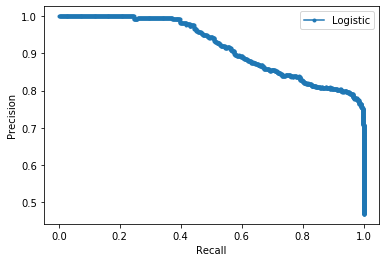

Logistic: AP=0.917


In [22]:
# Compute precision, recall and AP
lr_precision = []
lr_recall = []
for index_threshold in range(0, len(sorted_distances)-1):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for index, signature in enumerate(sorted_distances):
        if(index <= index_threshold):
            if predictions[signature] == 'g':
                tp = tp + 1
            else:
                fp = fp + 1
        else:
            if predictions[signature] == 'g':
                fn = fn + 1
            else:
                tn = tn + 1
    if (tp+fp) == 0:
        precision = 1
    else:
        precision = tp / (tp + fp)
    if (tp+fn) == 0:
        recall = 0
    else:
        recall = tp / (tp + fn)
    lr_precision.append(precision)
    lr_recall.append(recall)
lr_auc = auc(lr_recall, lr_precision)
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()
print('Logistic: AP=%.3f' % lr_auc)